## Importing libraries

In [2]:
import networkx as nx
import pandas as pd
import networkx.algorithms.community as nx_comm
import community as community_louvain
import matplotlib.cm as cm
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import powerlaw

#### the list of all airlines (open source dataset)

In [23]:
airports_ext = pd.read_csv('https://raw.githubusercontent.com/VladislavsLuksha/European_Air_Transportation_Network/main/DATA/Flights%20Data/OpenFlights/airports.csv')
airports_ext = airports_ext.iloc[:,:9]
airports_ext.head()

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146


#### the list of all airports (open source dataset)

In [24]:
from FlightRadar24.api import FlightRadar24API
fr_api = FlightRadar24API()


In [25]:
airports = fr_api.get_airports()

In [26]:
airports = pd.DataFrame(airports)
airports.head()

,name,iata,icao,lat,lon,country,alt
0,A Coruna Airport,LCG,LECO,43.302059,-8.377250,Spain,326
1,Aachen Merzbruck Airport,AAH,EDKA,50.823051,6.186111,Germany,623
2,Aalborg Airport,AAL,EKYT,57.092781,9.849164,Denmark,10
3,Aarhus Airport,AAR,EKAH,56.300011,10.619000,Denmark,82
4,Aarhus Sea Airport,QEA,EKAC,56.151993,10.247725,Denmark,1


In [27]:
airports = airports.dropna()

In [28]:
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5055 entries, 0 to 5054
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   name     5055 non-null   object 
 1   iata     5055 non-null   object 
 2   icao     5055 non-null   object 
 3   lat      5055 non-null   float64
 4   lon      5055 non-null   float64
 5   country  5055 non-null   object 
 6   alt      5055 non-null   object 
dtypes: float64(2), object(5)
memory usage: 276.6+ KB


#### South America airports

In [29]:
# Define the latitude and longitude ranges for South America
lat_min = -55.95
lat_max = 13.71
long_min = -90.86
long_max = -34.79

# Filter the DataFrame to only include locations within the boundaries
airports_sam = airports[(airports['lat'] >= lat_min) & (airports['lat'] <= lat_max) &
        (airports['lon'] >= long_min) & (airports['lon'] <= long_max)]

In [30]:
import folium

# Define the center point for the map
center_lat = (lat_min + lat_max) / 2
center_long = (long_min + long_max) / 2

# Create a map centered on the defined center point
m = folium.Map(location=[center_lat, center_long], zoom_start=3)

# Add a rectangle to the map to represent the boundaries
folium.Rectangle(
    bounds = [[lat_min, long_min], [lat_max, long_max]],
    color='green',
    fill= False
).add_to(m)

# Add markers for each airport in the DataFrame
for index, row in airports_sam.iterrows():
   if lat_min <= row['lat'] <= lat_max and long_min <= row['lon'] <= long_max:
        radius = 2  # Change the radius to adjust the size of the dots
        color = 'green'  # Change the color of the dots
        fill_color = 'green'  # Change the fill color of the dots
        fill_opacity = 0.2  # Change the fill opacity of the dots
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=radius,
            color=color,
            fill_color=fill_color,
            fill_opacity=fill_opacity,
            tooltip=row['name']
        ).add_to(m)

# Show the map
m

In [31]:
airports_sam.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 431 entries, 42 to 4997
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   name     431 non-null    object 
 1   iata     431 non-null    object 
 2   icao     431 non-null    object 
 3   lat      431 non-null    float64
 4   lon      431 non-null    float64
 5   country  431 non-null    object 
 6   alt      431 non-null    object 
dtypes: float64(2), object(5)
memory usage: 26.9+ KB


# THE CODE FOR OBTAINING SCHEDULES

In [112]:
#getting data for the south american airports

In [113]:
import pandas as pd
from tqdm import tqdm
import requests
import json

# Replace [API_KEY] with your own API key
API_KEY = '____'

# Define the start and end dates
start_date = '2023-01-21'
end_date = '2023-01-28'

airport_codes= list(airports_sam['iata'].unique())

# Initialize an empty list to store the API responses
responses = []

# Loop over the list of airport codes
for airport in tqdm(airport_codes, desc='Getting timetable'):
    # Make a GET request to the API
    url = f'https://aviation-edge.com/v2/public/flightsHistory?key={API_KEY}&code={airport}&type=departure&date_from={start_date}&date_to={end_date}'
    response = requests.get(url,timeout=30)
    
    # Add the API response to the list
    try:
        responses.append(response.json())
    except json.JSONDecodeError as e:
        print(f'Error decoding JSON response for {airport}: {e}')

Getting timetable: 100%|██████████████████████| 429/429 [03:45<00:00,  1.91it/s]


In [114]:
df_list = []
for sublist in responses:
    try:
        df_list.append(pd.DataFrame(sublist))
    except ValueError as e:
        print("Error while converting JSON to dataframe:", e)

df = pd.concat(df_list)

Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, you must pass an index
Error while converting JSON to dataframe: If using all scalar values, 

In [115]:
#df= df.drop(columns ='codeshared')
df = df.reset_index(drop=True)
df.head()

,type,status,departure,arrival,airline,flight,codeshared
0,departure,active,"{'iataCode': 'afl', 'icaoCode': 'sbat', 'delay...","{'iataCode': 'cgb', 'icaoCode': 'sbcy', 'gate'...","{'name': 'azul', 'iataCode': 'ad', 'icaoCode':...","{'number': '4535', 'iataNumber': 'ad4535', 'ic...",NaN
1,departure,active,"{'iataCode': 'afl', 'icaoCode': 'sbat', 'sched...","{'iataCode': 'cgb', 'icaoCode': 'sbcy', 'gate'...","{'name': 'azul', 'iataCode': 'ad', 'icaoCode':...","{'number': '4535', 'iataNumber': 'ad4535', 'ic...",NaN
2,departure,active,"{'iataCode': 'afl', 'icaoCode': 'sbat', 'sched...","{'iataCode': 'cgb', 'icaoCode': 'sbcy', 'gate'...","{'name': 'azul', 'iataCode': 'ad', 'icaoCode':...","{'number': '4535', 'iataNumber': 'ad4535', 'ic...",NaN
3,departure,active,"{'iataCode': 'afl', 'icaoCode': 'sbat', 'sched...","{'iataCode': 'cgb', 'icaoCode': 'sbcy', 'gate'...","{'name': 'azul', 'iataCode': 'ad', 'icaoCode':...","{'number': '4535', 'iataNumber': 'ad4535', 'ic...",NaN
4,departure,active,"{'iataCode': 'afl', 'icaoCode': 'sbat', 'delay...","{'iataCode': 'cgb', 'icaoCode': 'sbcy', 'gate'...","{'name': 'azul', 'iataCode': 'ad', 'icaoCode':...","{'number': '4535', 'iataNumber': 'ad4535', 'ic...",NaN


In [116]:
df = df.drop(columns = ['type'])

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84005 entries, 0 to 84004
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   status      84005 non-null  object
 1   departure   84005 non-null  object
 2   arrival     84005 non-null  object
 3   airline     84005 non-null  object
 4   flight      84005 non-null  object
 5   codeshared  36194 non-null  object
dtypes: object(6)
memory usage: 3.8+ MB


In [118]:
# Use pandas.json_normalize() to extract the values from the dictionaries
departures = pd.json_normalize(df['departure'])

# Rename the columns to include 'departure' and the dictionary key
departures.columns = ['departure_' + col for col in departures.columns]

# Concatenate the original DataFrame and the new departures DataFrame
ndf = pd.concat([df, departures], axis=1)

# Drop the original 'departure' column
ndf = ndf.drop('departure', axis=1)

# Print the resulting DataFrame
ndf.head()

,status,arrival,airline,flight,codeshared,departure_iataCode,departure_icaoCode,departure_delay,departure_scheduledTime,departure_estimatedTime,departure_actualTime,departure_estimatedRunway,departure_actualRunway,departure_terminal,departure_gate
0,active,"{'iataCode': 'cgb', 'icaoCode': 'sbcy', 'gate'...","{'name': 'azul', 'iataCode': 'ad', 'icaoCode':...","{'number': '4535', 'iataNumber': 'ad4535', 'ic...",NaN,afl,sbat,2.0,2023-01-21t13:45:00.000,2023-01-21t13:45:00.000,2023-01-21t13:46:00.000,2023-01-21t13:46:00.000,2023-01-21t13:46:00.000,NaN,NaN
1,active,"{'iataCode': 'cgb', 'icaoCode': 'sbcy', 'gate'...","{'name': 'azul', 'iataCode': 'ad', 'icaoCode':...","{'number': '4535', 'iataNumber': 'ad4535', 'ic...",NaN,afl,sbat,NaN,2023-01-22t13:45:00.000,NaN,2023-01-22t13:42:00.000,2023-01-22t13:42:00.000,2023-01-22t13:42:00.000,NaN,NaN
2,active,"{'iataCode': 'cgb', 'icaoCode': 'sbcy', 'gate'...","{'name': 'azul', 'iataCode': 'ad', 'icaoCode':...","{'number': '4535', 'iataNumber': 'ad4535', 'ic...",NaN,afl,sbat,NaN,2023-01-23t13:45:00.000,NaN,NaN,NaN,NaN,NaN,NaN
3,active,"{'iataCode': 'cgb', 'icaoCode': 'sbcy', 'gate'...","{'name': 'azul', 'iataCode': 'ad', 'icaoCode':...","{'number': '4535', 'iataNumber': 'ad4535', 'ic...",NaN,afl,sbat,NaN,2023-01-25t13:45:00.000,NaN,NaN,NaN,NaN,NaN,NaN
4,active,"{'iataCode': 'cgb', 'icaoCode': 'sbcy', 'gate'...","{'name': 'azul', 'iataCode': 'ad', 'icaoCode':...","{'number': '4535', 'iataNumber': 'ad4535', 'ic...",NaN,afl,sbat,13.0,2023-01-26t13:45:00.000,NaN,2023-01-26t13:58:00.000,2023-01-26t13:58:00.000,2023-01-26t13:58:00.000,NaN,NaN


In [119]:
ndf = ndf.drop(columns = ['departure_icaoCode','departure_actualTime', 'departure_estimatedRunway' , 'departure_actualRunway', 'departure_terminal' , 'departure_gate', 'departure_estimatedTime'])
ndf.head()

,status,arrival,airline,flight,codeshared,departure_iataCode,departure_delay,departure_scheduledTime
0,active,"{'iataCode': 'cgb', 'icaoCode': 'sbcy', 'gate'...","{'name': 'azul', 'iataCode': 'ad', 'icaoCode':...","{'number': '4535', 'iataNumber': 'ad4535', 'ic...",NaN,afl,2.0,2023-01-21t13:45:00.000
1,active,"{'iataCode': 'cgb', 'icaoCode': 'sbcy', 'gate'...","{'name': 'azul', 'iataCode': 'ad', 'icaoCode':...","{'number': '4535', 'iataNumber': 'ad4535', 'ic...",NaN,afl,NaN,2023-01-22t13:45:00.000
2,active,"{'iataCode': 'cgb', 'icaoCode': 'sbcy', 'gate'...","{'name': 'azul', 'iataCode': 'ad', 'icaoCode':...","{'number': '4535', 'iataNumber': 'ad4535', 'ic...",NaN,afl,NaN,2023-01-23t13:45:00.000
3,active,"{'iataCode': 'cgb', 'icaoCode': 'sbcy', 'gate'...","{'name': 'azul', 'iataCode': 'ad', 'icaoCode':...","{'number': '4535', 'iataNumber': 'ad4535', 'ic...",NaN,afl,NaN,2023-01-25t13:45:00.000
4,active,"{'iataCode': 'cgb', 'icaoCode': 'sbcy', 'gate'...","{'name': 'azul', 'iataCode': 'ad', 'icaoCode':...","{'number': '4535', 'iataNumber': 'ad4535', 'ic...",NaN,afl,13.0,2023-01-26t13:45:00.000


In [120]:
# Use pandas.json_normalize() to extract the values from the dictionaries
arrivals = pd.json_normalize(ndf['arrival'])

# Rename the columns to include 'arrival' and the dictionary key
arrivals.columns = ['arrival_' + col for col in arrivals.columns]

# Concatenate the original DataFrame and the new departures DataFrame
ndf = pd.concat([ndf, arrivals], axis=1)

# Drop the original 'departure' column
ndf = ndf.drop('arrival', axis=1)

# Print the resulting DataFrame
ndf.head()

,status,airline,flight,codeshared,departure_iataCode,departure_delay,departure_scheduledTime,arrival_iataCode,arrival_icaoCode,arrival_gate,arrival_scheduledTime,arrival_estimatedTime,arrival_delay,arrival_baggage,arrival_actualTime,arrival_estimatedRunway,arrival_actualRunway,arrival_terminal
0,active,"{'name': 'azul', 'iataCode': 'ad', 'icaoCode':...","{'number': '4535', 'iataNumber': 'ad4535', 'ic...",NaN,afl,2.0,2023-01-21t13:45:00.000,cgb,sbcy,9,2023-01-21t15:00:00.000,2023-01-21t14:55:00.000,NaN,NaN,NaN,NaN,NaN,NaN
1,active,"{'name': 'azul', 'iataCode': 'ad', 'icaoCode':...","{'number': '4535', 'iataNumber': 'ad4535', 'ic...",NaN,afl,NaN,2023-01-22t13:45:00.000,cgb,sbcy,7,2023-01-22t15:00:00.000,2023-01-22t14:48:00.000,NaN,NaN,NaN,NaN,NaN,NaN
2,active,"{'name': 'azul', 'iataCode': 'ad', 'icaoCode':...","{'number': '4535', 'iataNumber': 'ad4535', 'ic...",NaN,afl,NaN,2023-01-23t13:45:00.000,cgb,sbcy,8,2023-01-23t15:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,active,"{'name': 'azul', 'iataCode': 'ad', 'icaoCode':...","{'number': '4535', 'iataNumber': 'ad4535', 'ic...",NaN,afl,NaN,2023-01-25t13:45:00.000,cgb,sbcy,9,2023-01-25t15:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,active,"{'name': 'azul', 'iataCode': 'ad', 'icaoCode':...","{'number': '4535', 'iataNumber': 'ad4535', 'ic...",NaN,afl,13.0,2023-01-26t13:45:00.000,cgb,sbcy,8,2023-01-26t15:00:00.000,2023-01-26t15:05:00.000,6.0,NaN,NaN,NaN,NaN,NaN


In [121]:
ndf = ndf.drop(columns = [ 'arrival_icaoCode' , 'arrival_terminal', 'arrival_baggage' ,'arrival_actualTime', 'arrival_estimatedTime', 'arrival_estimatedRunway','arrival_actualRunway','arrival_gate'])
ndf.head()

,status,airline,flight,codeshared,departure_iataCode,departure_delay,departure_scheduledTime,arrival_iataCode,arrival_scheduledTime,arrival_delay
0,active,"{'name': 'azul', 'iataCode': 'ad', 'icaoCode':...","{'number': '4535', 'iataNumber': 'ad4535', 'ic...",NaN,afl,2.0,2023-01-21t13:45:00.000,cgb,2023-01-21t15:00:00.000,NaN
1,active,"{'name': 'azul', 'iataCode': 'ad', 'icaoCode':...","{'number': '4535', 'iataNumber': 'ad4535', 'ic...",NaN,afl,NaN,2023-01-22t13:45:00.000,cgb,2023-01-22t15:00:00.000,NaN
2,active,"{'name': 'azul', 'iataCode': 'ad', 'icaoCode':...","{'number': '4535', 'iataNumber': 'ad4535', 'ic...",NaN,afl,NaN,2023-01-23t13:45:00.000,cgb,2023-01-23t15:00:00.000,NaN
3,active,"{'name': 'azul', 'iataCode': 'ad', 'icaoCode':...","{'number': '4535', 'iataNumber': 'ad4535', 'ic...",NaN,afl,NaN,2023-01-25t13:45:00.000,cgb,2023-01-25t15:00:00.000,NaN
4,active,"{'name': 'azul', 'iataCode': 'ad', 'icaoCode':...","{'number': '4535', 'iataNumber': 'ad4535', 'ic...",NaN,afl,13.0,2023-01-26t13:45:00.000,cgb,2023-01-26t15:00:00.000,6.0


In [122]:
# Use pandas.json_normalize() to extract the values from the dictionaries
airlines = pd.json_normalize(ndf['airline'])

# Rename the columns to include 'airline' and the dictionary key
airlines.columns = ['airline_' + col for col in airlines.columns]

# Concatenate the original DataFrame and the new departures DataFrame
ndf = pd.concat([ndf, airlines], axis=1)

# Drop the original 'departure' column
ndf = ndf.drop('airline', axis=1)

# Print the resulting DataFrame
ndf.head()

,status,flight,codeshared,departure_iataCode,departure_delay,departure_scheduledTime,arrival_iataCode,arrival_scheduledTime,arrival_delay,airline_name,airline_iataCode,airline_icaoCode
0,active,"{'number': '4535', 'iataNumber': 'ad4535', 'ic...",NaN,afl,2.0,2023-01-21t13:45:00.000,cgb,2023-01-21t15:00:00.000,NaN,azul,ad,azu
1,active,"{'number': '4535', 'iataNumber': 'ad4535', 'ic...",NaN,afl,NaN,2023-01-22t13:45:00.000,cgb,2023-01-22t15:00:00.000,NaN,azul,ad,azu
2,active,"{'number': '4535', 'iataNumber': 'ad4535', 'ic...",NaN,afl,NaN,2023-01-23t13:45:00.000,cgb,2023-01-23t15:00:00.000,NaN,azul,ad,azu
3,active,"{'number': '4535', 'iataNumber': 'ad4535', 'ic...",NaN,afl,NaN,2023-01-25t13:45:00.000,cgb,2023-01-25t15:00:00.000,NaN,azul,ad,azu
4,active,"{'number': '4535', 'iataNumber': 'ad4535', 'ic...",NaN,afl,13.0,2023-01-26t13:45:00.000,cgb,2023-01-26t15:00:00.000,6.0,azul,ad,azu


In [123]:
ndf = ndf.drop(columns = [ 'airline_icaoCode'])


In [124]:
# Use pandas.json_normalize() to extract the values from the dictionaries
flights = pd.json_normalize(ndf['flight'])

# Rename the columns to include 'flight' and the dictionary key
flights.columns = ['flight_' + col for col in flights.columns]

# Concatenate the original DataFrame and the new flights DataFrame
ndf = pd.concat([ndf, flights], axis=1)

# Drop the original 'flights' column
ndf = ndf.drop('flight', axis=1)

# Print the resulting DataFrame
ndf.head()

,status,codeshared,departure_iataCode,departure_delay,departure_scheduledTime,arrival_iataCode,arrival_scheduledTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber,flight_icaoNumber
0,active,NaN,afl,2.0,2023-01-21t13:45:00.000,cgb,2023-01-21t15:00:00.000,NaN,azul,ad,4535,ad4535,azu4535
1,active,NaN,afl,NaN,2023-01-22t13:45:00.000,cgb,2023-01-22t15:00:00.000,NaN,azul,ad,4535,ad4535,azu4535
2,active,NaN,afl,NaN,2023-01-23t13:45:00.000,cgb,2023-01-23t15:00:00.000,NaN,azul,ad,4535,ad4535,azu4535
3,active,NaN,afl,NaN,2023-01-25t13:45:00.000,cgb,2023-01-25t15:00:00.000,NaN,azul,ad,4535,ad4535,azu4535
4,active,NaN,afl,13.0,2023-01-26t13:45:00.000,cgb,2023-01-26t15:00:00.000,6.0,azul,ad,4535,ad4535,azu4535


In [125]:
ndf = ndf.drop(columns = ['flight_icaoNumber'])
ndf.head()

,status,codeshared,departure_iataCode,departure_delay,departure_scheduledTime,arrival_iataCode,arrival_scheduledTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber
0,active,NaN,afl,2.0,2023-01-21t13:45:00.000,cgb,2023-01-21t15:00:00.000,NaN,azul,ad,4535,ad4535
1,active,NaN,afl,NaN,2023-01-22t13:45:00.000,cgb,2023-01-22t15:00:00.000,NaN,azul,ad,4535,ad4535
2,active,NaN,afl,NaN,2023-01-23t13:45:00.000,cgb,2023-01-23t15:00:00.000,NaN,azul,ad,4535,ad4535
3,active,NaN,afl,NaN,2023-01-25t13:45:00.000,cgb,2023-01-25t15:00:00.000,NaN,azul,ad,4535,ad4535
4,active,NaN,afl,13.0,2023-01-26t13:45:00.000,cgb,2023-01-26t15:00:00.000,6.0,azul,ad,4535,ad4535


In [126]:
# Use pandas.json_normalize() to extract the values from the dictionaries
codeshared = pd.json_normalize(ndf['codeshared'])

# Rename the columns to include 'codeshared' and the dictionary key
codeshared.columns = ['codeshared_' + col for col in codeshared.columns]

# Concatenate the original DataFrame and the new codeshared DataFrame
ndf = pd.concat([ndf, codeshared], axis=1)

# Drop the original 'codeshared' column
ndf = ndf.drop('codeshared', axis=1)

# Print the resulting DataFrame
ndf.head()

,status,departure_iataCode,departure_delay,departure_scheduledTime,arrival_iataCode,arrival_scheduledTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber,codeshared_airline.name,codeshared_airline.iataCode,codeshared_airline.icaoCode,codeshared_flight.number,codeshared_flight.iataNumber,codeshared_flight.icaoNumber
0,active,afl,2.0,2023-01-21t13:45:00.000,cgb,2023-01-21t15:00:00.000,NaN,azul,ad,4535,ad4535,NaN,NaN,NaN,NaN,NaN,NaN
1,active,afl,NaN,2023-01-22t13:45:00.000,cgb,2023-01-22t15:00:00.000,NaN,azul,ad,4535,ad4535,NaN,NaN,NaN,NaN,NaN,NaN
2,active,afl,NaN,2023-01-23t13:45:00.000,cgb,2023-01-23t15:00:00.000,NaN,azul,ad,4535,ad4535,NaN,NaN,NaN,NaN,NaN,NaN
3,active,afl,NaN,2023-01-25t13:45:00.000,cgb,2023-01-25t15:00:00.000,NaN,azul,ad,4535,ad4535,NaN,NaN,NaN,NaN,NaN,NaN
4,active,afl,13.0,2023-01-26t13:45:00.000,cgb,2023-01-26t15:00:00.000,6.0,azul,ad,4535,ad4535,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:
ndf = ndf.drop(columns = [ 'codeshared_airline.iataCode','codeshared_airline.icaoCode','codeshared_flight.number','codeshared_flight.icaoNumber'])
ndf.head()

,status,departure_iataCode,departure_delay,departure_scheduledTime,arrival_iataCode,arrival_scheduledTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber,codeshared_airline.name,codeshared_flight.iataNumber
0,active,afl,2.0,2023-01-21t13:45:00.000,cgb,2023-01-21t15:00:00.000,NaN,azul,ad,4535,ad4535,NaN,NaN
1,active,afl,NaN,2023-01-22t13:45:00.000,cgb,2023-01-22t15:00:00.000,NaN,azul,ad,4535,ad4535,NaN,NaN
2,active,afl,NaN,2023-01-23t13:45:00.000,cgb,2023-01-23t15:00:00.000,NaN,azul,ad,4535,ad4535,NaN,NaN
3,active,afl,NaN,2023-01-25t13:45:00.000,cgb,2023-01-25t15:00:00.000,NaN,azul,ad,4535,ad4535,NaN,NaN
4,active,afl,13.0,2023-01-26t13:45:00.000,cgb,2023-01-26t15:00:00.000,6.0,azul,ad,4535,ad4535,NaN,NaN


In [128]:
ndf.loc[ndf['codeshared_airline.name'].isnull(), 'codeshared_airline.name'] = ndf.loc[ndf['codeshared_airline.name'].isnull(), 'airline_name']
ndf.loc[ndf['codeshared_flight.iataNumber'].isnull(), 'codeshared_flight.iataNumber'] = ndf.loc[ndf['codeshared_flight.iataNumber'].isnull(), 'flight_iataNumber']
ndf['departure_delay'].fillna(0, inplace=True)


In [129]:
ndf.loc[ndf['arrival_delay'].isnull(), 'arrival_delay'] = ndf.loc[ndf['arrival_delay'].isnull(), 'departure_delay']
ndf[['departure_iataCode', 'arrival_iataCode']] = ndf[['departure_iataCode', 'arrival_iataCode']].applymap(str.upper)

In [130]:
ndf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84005 entries, 0 to 84004
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   status                        84005 non-null  object 
 1   departure_iataCode            84005 non-null  object 
 2   departure_delay               84005 non-null  float64
 3   departure_scheduledTime       84005 non-null  object 
 4   arrival_iataCode              84005 non-null  object 
 5   arrival_scheduledTime         84005 non-null  object 
 6   arrival_delay                 84005 non-null  float64
 7   airline_name                  84005 non-null  object 
 8   airline_iataCode              84005 non-null  object 
 9   flight_number                 84005 non-null  object 
 10  flight_iataNumber             84005 non-null  object 
 11  codeshared_airline.name       84005 non-null  object 
 12  codeshared_flight.iataNumber  84005 non-null  object 
dtypes

In [131]:
ndf.head()

,status,departure_iataCode,departure_delay,departure_scheduledTime,arrival_iataCode,arrival_scheduledTime,arrival_delay,airline_name,airline_iataCode,flight_number,flight_iataNumber,codeshared_airline.name,codeshared_flight.iataNumber
0,active,AFL,2.0,2023-01-21t13:45:00.000,CGB,2023-01-21t15:00:00.000,2.0,azul,ad,4535,ad4535,azul,ad4535
1,active,AFL,0.0,2023-01-22t13:45:00.000,CGB,2023-01-22t15:00:00.000,0.0,azul,ad,4535,ad4535,azul,ad4535
2,active,AFL,0.0,2023-01-23t13:45:00.000,CGB,2023-01-23t15:00:00.000,0.0,azul,ad,4535,ad4535,azul,ad4535
3,active,AFL,0.0,2023-01-25t13:45:00.000,CGB,2023-01-25t15:00:00.000,0.0,azul,ad,4535,ad4535,azul,ad4535
4,active,AFL,13.0,2023-01-26t13:45:00.000,CGB,2023-01-26t15:00:00.000,6.0,azul,ad,4535,ad4535,azul,ad4535


# ANALYSIS PART

In [4]:
ndf = pd.read_csv('https://raw.githubusercontent.com/VladislavsLuksha/European_Air_Transportation_Network/main/DATA/Flights%20Data/codeshared/allflights23southam21012801.csv')

In [5]:
eur_g1 = ndf[ndf['flight_iataNumber'] == ndf['codeshared_flight.iataNumber']]

In [6]:
eur_g1 = eur_g1[eur_g1['status'] == 'active']

In [7]:
eur_g1 = eur_g1.drop_duplicates(subset=['departure_iataCode', 'departure_scheduledTime', 'arrival_iataCode'])

In [8]:
eur_g = eur_g1.drop(columns = ['status','departure_scheduledTime','departure_delay','flight_iataNumber','arrival_scheduledTime','arrival_delay','airline_iataCode','flight_number','codeshared_airline.name','codeshared_flight.iataNumber'])

In [9]:
eur_g = eur_g[eur_g['departure_iataCode'] != eur_g['arrival_iataCode']]


In [10]:
###------------

In [11]:
df_grouped = eur_g.groupby(eur_g.columns.tolist()).size().reset_index(name='counts')

# Reset the index to remove the old index and create a new one
df_grouped = df_grouped.reset_index(drop=True)
df_grouped.sort_values('counts', ascending=False).head(20)

,Unnamed: 0,departure_iataCode,arrival_iataCode,airline_name,counts
0,0,AFL,CGB,azul,1
29391,52325,UIO,GYE,equair,1
29383,52316,UIO,PTY,copa airlines,1
29384,52317,UIO,BOG,sa avianca,1
29385,52318,UIO,MEC,sa avianca,1
29386,52320,UIO,PTY,copa airlines,1
29387,52321,UIO,GYE,equair,1
29388,52322,UIO,GYE,latam airlines,1
29389,52323,UIO,MIA,american airlines,1
29390,52324,UIO,GYE,latam airlines,1


In [12]:
df_grouped['counts'] = round(df_grouped['counts'])


In [13]:
dflights_j =  df_grouped.merge(airports_ext, left_on='departure_iataCode', right_on='IATA')

In [14]:
dflights_j = dflights_j.drop(columns=['ICAO','IATA'])
dflights_j.head()

,Unnamed: 0,departure_iataCode,arrival_iataCode,airline_name,counts,Airport ID,Name,City,Country,Latitude,Longitude,Altitude
0,0,AFL,CGB,azul,1,2524,Piloto Osvaldo Marques Dias Airport,Alta Floresta,Brazil,-9.866389,-56.105,948
1,1,AFL,CGB,azul,1,2524,Piloto Osvaldo Marques Dias Airport,Alta Floresta,Brazil,-9.866389,-56.105,948
2,2,AFL,CGB,azul,1,2524,Piloto Osvaldo Marques Dias Airport,Alta Floresta,Brazil,-9.866389,-56.105,948
3,3,AFL,CGB,azul,1,2524,Piloto Osvaldo Marques Dias Airport,Alta Floresta,Brazil,-9.866389,-56.105,948
4,4,AFL,CGB,azul,1,2524,Piloto Osvaldo Marques Dias Airport,Alta Floresta,Brazil,-9.866389,-56.105,948


In [15]:
dflights_j = dflights_j.loc[:,['Airport ID','departure_iataCode','arrival_iataCode','Name','City','Country','Latitude','Longitude','airline_name','counts']]
dflights_j = dflights_j.rename(columns={"City": "City_origin", "Latitude":"Latitude_origin", "Longitude": "Longitude_origin", 'Country':'Country_origin','Name':'Name_origin','departure':'code_origin','arrival':'code_dest'})
dflights_j.head()

,Airport ID,departure_iataCode,arrival_iataCode,Name_origin,City_origin,Country_origin,Latitude_origin,Longitude_origin,airline_name,counts
0,2524,AFL,CGB,Piloto Osvaldo Marques Dias Airport,Alta Floresta,Brazil,-9.866389,-56.105,azul,1
1,2524,AFL,CGB,Piloto Osvaldo Marques Dias Airport,Alta Floresta,Brazil,-9.866389,-56.105,azul,1
2,2524,AFL,CGB,Piloto Osvaldo Marques Dias Airport,Alta Floresta,Brazil,-9.866389,-56.105,azul,1
3,2524,AFL,CGB,Piloto Osvaldo Marques Dias Airport,Alta Floresta,Brazil,-9.866389,-56.105,azul,1
4,2524,AFL,CGB,Piloto Osvaldo Marques Dias Airport,Alta Floresta,Brazil,-9.866389,-56.105,azul,1


In [16]:
dflights_j =  dflights_j.merge(airports_ext, left_on='arrival_iataCode', right_on='IATA')
dflights_j.head()

,Airport ID_x,departure_iataCode,arrival_iataCode,Name_origin,City_origin,Country_origin,Latitude_origin,Longitude_origin,airline_name,counts,Airport ID_y,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude
0,2524,AFL,CGB,Piloto Osvaldo Marques Dias Airport,Alta Floresta,Brazil,-9.866389,-56.105,azul,1,2548,Marechal Rondon Airport,Cuiaba,Brazil,CGB,SBCY,-15.6529,-56.116699,617
1,2524,AFL,CGB,Piloto Osvaldo Marques Dias Airport,Alta Floresta,Brazil,-9.866389,-56.105,azul,1,2548,Marechal Rondon Airport,Cuiaba,Brazil,CGB,SBCY,-15.6529,-56.116699,617
2,2524,AFL,CGB,Piloto Osvaldo Marques Dias Airport,Alta Floresta,Brazil,-9.866389,-56.105,azul,1,2548,Marechal Rondon Airport,Cuiaba,Brazil,CGB,SBCY,-15.6529,-56.116699,617
3,2524,AFL,CGB,Piloto Osvaldo Marques Dias Airport,Alta Floresta,Brazil,-9.866389,-56.105,azul,1,2548,Marechal Rondon Airport,Cuiaba,Brazil,CGB,SBCY,-15.6529,-56.116699,617
4,2524,AFL,CGB,Piloto Osvaldo Marques Dias Airport,Alta Floresta,Brazil,-9.866389,-56.105,azul,1,2548,Marechal Rondon Airport,Cuiaba,Brazil,CGB,SBCY,-15.6529,-56.116699,617


In [17]:
dflights_j = dflights_j.drop(columns=['ICAO','IATA'])
dflights_j.head()

,Airport ID_x,departure_iataCode,arrival_iataCode,Name_origin,City_origin,Country_origin,Latitude_origin,Longitude_origin,airline_name,counts,Airport ID_y,Name,City,Country,Latitude,Longitude,Altitude
0,2524,AFL,CGB,Piloto Osvaldo Marques Dias Airport,Alta Floresta,Brazil,-9.866389,-56.105,azul,1,2548,Marechal Rondon Airport,Cuiaba,Brazil,-15.6529,-56.116699,617
1,2524,AFL,CGB,Piloto Osvaldo Marques Dias Airport,Alta Floresta,Brazil,-9.866389,-56.105,azul,1,2548,Marechal Rondon Airport,Cuiaba,Brazil,-15.6529,-56.116699,617
2,2524,AFL,CGB,Piloto Osvaldo Marques Dias Airport,Alta Floresta,Brazil,-9.866389,-56.105,azul,1,2548,Marechal Rondon Airport,Cuiaba,Brazil,-15.6529,-56.116699,617
3,2524,AFL,CGB,Piloto Osvaldo Marques Dias Airport,Alta Floresta,Brazil,-9.866389,-56.105,azul,1,2548,Marechal Rondon Airport,Cuiaba,Brazil,-15.6529,-56.116699,617
4,2524,AFL,CGB,Piloto Osvaldo Marques Dias Airport,Alta Floresta,Brazil,-9.866389,-56.105,azul,1,2548,Marechal Rondon Airport,Cuiaba,Brazil,-15.6529,-56.116699,617


In [18]:
dflights_j = dflights_j.rename(columns={"City": "City_dest", "Latitude":"Latitude_dest", "Longitude": "Longitude_dest", 'Country':'Country_dest','Name':'Name_dest'})
dflights_j.head()


,Airport ID_x,departure_iataCode,arrival_iataCode,Name_origin,City_origin,Country_origin,Latitude_origin,Longitude_origin,airline_name,counts,Airport ID_y,Name_dest,City_dest,Country_dest,Latitude_dest,Longitude_dest,Altitude
0,2524,AFL,CGB,Piloto Osvaldo Marques Dias Airport,Alta Floresta,Brazil,-9.866389,-56.105,azul,1,2548,Marechal Rondon Airport,Cuiaba,Brazil,-15.6529,-56.116699,617
1,2524,AFL,CGB,Piloto Osvaldo Marques Dias Airport,Alta Floresta,Brazil,-9.866389,-56.105,azul,1,2548,Marechal Rondon Airport,Cuiaba,Brazil,-15.6529,-56.116699,617
2,2524,AFL,CGB,Piloto Osvaldo Marques Dias Airport,Alta Floresta,Brazil,-9.866389,-56.105,azul,1,2548,Marechal Rondon Airport,Cuiaba,Brazil,-15.6529,-56.116699,617
3,2524,AFL,CGB,Piloto Osvaldo Marques Dias Airport,Alta Floresta,Brazil,-9.866389,-56.105,azul,1,2548,Marechal Rondon Airport,Cuiaba,Brazil,-15.6529,-56.116699,617
4,2524,AFL,CGB,Piloto Osvaldo Marques Dias Airport,Alta Floresta,Brazil,-9.866389,-56.105,azul,1,2548,Marechal Rondon Airport,Cuiaba,Brazil,-15.6529,-56.116699,617


In [32]:
error_df = dflights_j[dflights_j['departure_iataCode'].isin(dflights_j['arrival_iataCode'].unique()) & ~dflights_j['arrival_iataCode'].isin(dflights_j['departure_iataCode'].unique())]
error_df = error_df[error_df['arrival_iataCode'].isin(airports_sam['iata'])]

# Create a new dataframe for the return flights
return_flights_df = error_df.copy()

# Swap the values in the appropriate columns to create the return flights
return_flights_df.rename(columns={
    'Airport ID_x': 'Airport ID_y',
    'Airport ID_y': 'Airport ID_x',
    'departure_iataCode': 'arrival_iataCode',
    'arrival_iataCode' : 'departure_iataCode',
    'Name_origin': 'Name_dest',
    'Name_dest': 'Name_origin',
    'City_origin': 'City_dest',
    'City_dest': 'City_origin',
    'Country_origin': 'Country_dest',
    'Country_dest': 'Country_origin',
    'Latitude_origin': 'Latitude_dest',
    'Latitude_dest': 'Latitude_origin',
    'Longitude_origin': 'Longitude_dest',
    'Longitude_dest': 'Longitude_origin',
    
}, inplace=True)

# Concatenate the existing dataframe and the return flights dataframe
new_df = pd.concat([dflights_j, return_flights_df], ignore_index=True)

# Save the new dataframe to a file or use it for further analysis
new_df.to_csv('SAMjanuary23.csv', index=False)

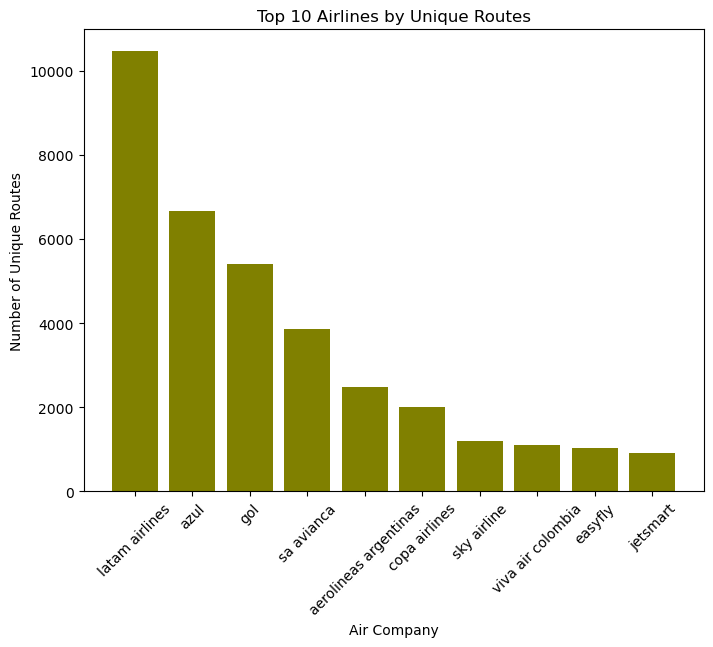

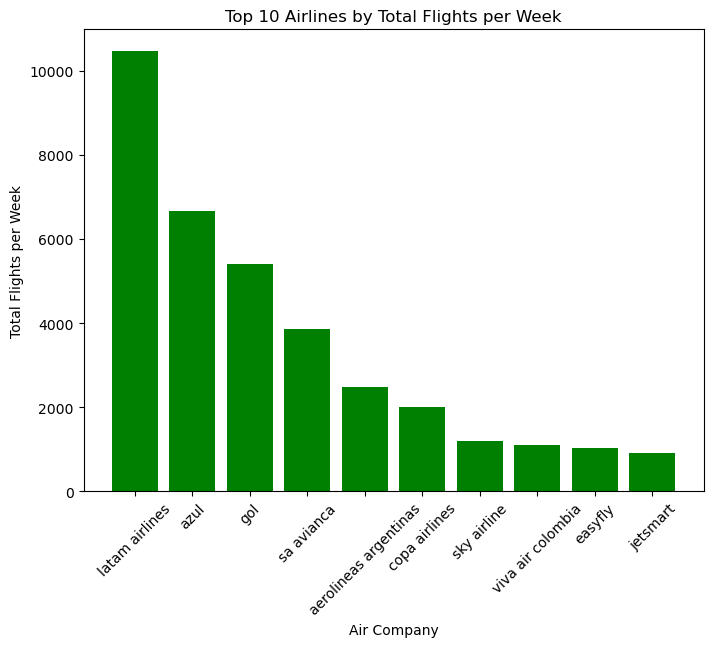

In [33]:
# Group the data by airline and count the number of unique routes for each airline
route_counts = new_df.groupby('airline_name').apply(lambda x: len(x[['departure_iataCode', 'arrival_iataCode']]))
route_counts = route_counts.sort_values(ascending=False)[:10]

# Create a bar chart showing the number of unique routes for each airline
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(route_counts.index, route_counts.values, color=['olive'])
ax.set_title('Top 10 Airlines by Unique Routes')
ax.set_xlabel('Air Company')
ax.set_ylabel('Number of Unique Routes')
plt.xticks(rotation=45)

# Group the data by airline and sum the number of flights for each airline
flight_counts = new_df.groupby('airline_name')['counts'].sum()
flight_counts = flight_counts.sort_values(ascending=False)[:10]

# Create a bar chart showing the total number of flights for each airline
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(flight_counts.index, flight_counts.values, color=['green'])
ax.set_title('Top 10 Airlines by Total Flights per Week')
ax.set_xlabel('Air Company')
ax.set_ylabel('Total Flights per Week')
plt.xticks(rotation=45)

plt.show()

In [21]:
from math import radians, sin, cos, sqrt, atan2
def distance(row):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(row['Latitude_origin'])
    lon1 = radians(row['Longitude_origin'])
    lat2 = radians(row['Latitude_dest'])
    lon2 = radians(row['Longitude_dest'])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance
new_df['distance'] = new_df.apply(distance, axis=1)

NameError: name 'new_df' is not defined

In [210]:
# Initialize the graph
L = nx.Graph()

# Add the nodes with their attributes
for i, row in new_df.iterrows():
    origin = row['Airport ID_x']
    destination = row['Airport ID_y']
    origin_lat = row['Latitude_origin']
    origin_long = row['Longitude_origin']
    destination_lat = row['Latitude_dest']
    destination_long = row['Longitude_dest']
    origin_city = row['City_origin']
    destination_city = row['City_dest']
    origin_code = row['departure_iataCode']
    dest_code =row['arrival_iataCode']
    origin_airportname = row['Name_origin']
    dest_airportname = row['Name_dest']
   
    
    L.add_node(origin, lat=origin_lat, lng=origin_long, city=origin_city, code=origin_code, airport = origin_airportname)
    L.add_node(destination, lat=destination_lat, lng=destination_long, city=destination_city, code=dest_code, airport = dest_airportname)

# Add the edges with the attributes
for i, row in new_df.iterrows():
    origin = row['Airport ID_x']
    destination = row['Airport ID_y']
    cnts = row['counts']
    airline_name = row['airline_name']
    kilometers = row['distance']
    
    L.add_edge(origin, destination, weight= kilometers, airline_name =airline_name )

# Save the graph to disk
#nx.write_gml(G, "flights_graph.gml")


nx.write_gexf(L, "graph2023_sam.gexf")

In [207]:
# Initialize the graph
F = nx.MultiDiGraph()

# Add the nodes with their attributes
for i, row in new_df.iterrows():
    origin = row['Airport ID_x']
    destination = row['Airport ID_y']
    origin_lat = row['Latitude_origin']
    origin_long = row['Longitude_origin']
    destination_lat = row['Latitude_dest']
    destination_long = row['Longitude_dest']
    origin_city = row['City_origin']
    destination_city = row['City_dest']
    origin_code = row['departure_iataCode']
    dest_code =row['arrival_iataCode']
    origin_airportname = row['Name_origin']
    dest_airportname = row['Name_dest']
   
    F.add_node(origin, lat=origin_lat, lng=origin_long, city=origin_city, code=origin_code, airport=origin_airportname)
    F.add_node(destination, lat=destination_lat, lng=destination_long, city=destination_city, code=dest_code, airport=dest_airportname)

# Add the edges with the attributes
for i, row in new_df.iterrows():
    origin = row['Airport ID_x']
    destination = row['Airport ID_y']
    cnts = row['counts']
    airline_name = row['airline_name']
    kilometers = row['distance']
    
    # Add a new edge with the count and airline name as attributes
    F.add_edge(origin, destination, weight=kilometers, airline_name=airline_name, number_flights = cnts)

# Write the graph to a file
nx.write_gexf(F, "fixed_graph2023_sam.gexf")


#### GRAPH ANALYSIS

In [209]:
print('Number of nodes: {} - Number of links: {}'.format(L.order(),L.size()))

Number of nodes: 450 - Number of links: 1559


the density of a graph is a measure of how many edges are present in the graph relative to the total number of possible edges. It is calculated as the ratio of the actual number of edges to the total number of possible edges in the graph.

In [151]:
L_density = nx.density(L)
print("Density: " + str(L_density))

Density: 0.015431823805988617


In [152]:
L_degree = list(dict(L.degree()).values())

In [153]:
print("South American Air Transportation Graph Degree statistics: ")
print("Mean: " + str(round(np.mean(L_degree),4)))
print("Median: " + str(np.median(L_degree))) 
print("Standard deviation: " + str(round(np.std(L_degree),4)))
print("Maximum: " + str(np.max(L_degree)))
print("Minimum: " + str(np.min(L_degree)))

South American Air Transportation Graph Degree statistics: 
Mean: 6.9289
Median: 2.0
Standard deviation: 12.4349
Maximum: 102
Minimum: 1


#### Minimum degree is 1, so there as no isolated nodes. Mean value is higher that median, so we deal with a scale-free network. To verify this we will check degree distribution and compare it to the random network degree distribution

A scale-free network is a type of network where the distribution of node degrees (the number of connections per node) follows a power law.
This means that a few nodes have a very high degree of connections, while most nodes have only a few connections.



In [162]:
percentile_99 = np.percentile(L_degree,99)
print(percentile_99)

59.50999999999999


In [163]:
#HUBS 

hub = [k for k,v in dict(L.degree()).items() if v>= percentile_99]
print('Number of hubs:',len(hub))
print('List of hubs:', list(hub))

print('Number of isolated nodes:', list(nx.isolates(L)))

Number of hubs: 5
List of hubs: [2709, 1871, 2564, 2650, 2578]
Number of isolated nodes: []


In [164]:
df_hubs = dflights_j[dflights_j['Airport ID_x'].isin(hub)]['City_origin'].unique()
print(df_hubs)
                            

['Bogota' 'Panama City' 'Sao Paulo' 'Santiago' 'Campinas']


In [165]:
print(nx.is_connected(L))
print(nx.number_connected_components(L))

True
1


In [166]:
components = nx.connected_components(L)
for i, component in enumerate(components):
    print(f"Airports in connected component {i+1}:")
    for airport in component:
        print(airport)
    print()

Airports in connected component 1:
8237
8238
8242
8245
8247
8253
8260
73
8274
111
4209
4213
4214
4215
4220
2188
146
178
189
193
4304
4305
4306
4330
6420
309
310
340
345
346
2439
2440
2441
2442
2443
2452
2454
2455
2456
2458
2460
2461
2462
2467
2468
2469
2470
2471
2474
2476
2477
2487
2488
2490
2491
2492
2495
2496
2497
2501
2508
2509
2512
2513
469
2517
2522
2524
2525
2526
2527
478
2531
2533
2534
2535
2537
2538
2539
494
2543
2544
2545
2547
2548
499
2550
2551
502
2549
2554
2555
507
2556
2559
2560
2562
2564
2566
2568
2569
2570
2572
2575
2576
2577
2578
2581
2584
2585
2586
2587
2590
2591
2592
2594
2595
2596
2597
2599
2600
2602
2603
2604
2606
2607
2609
2610
2612
2613
2616
2618
2619
2621
2622
2623
2624
2626
579
580
2628
2630
2631
2632
2633
2635
6732
6731
2638
6735
2636
2641
2642
2637
2645
2647
2649
2650
2651
2652
2654
2655
2656
2657
2658
2660
2662
2665
2667
2670
2671
2672
2673
629
6777
2683
2688
2690
2699
2705
2706
2708
2709
2710
2711
2712
2713
2714
2715
2716
2717
2718
2719
2722
2724
2725
2726
2

In [167]:
L_triangles_list = list(nx.triangles(L).values())

In [168]:
# get the number of triangles for each node
triangles = nx.triangles(L)

# print the number of triangles for each node
for node, num_triangles in triangles.items():
    print(f"Node {node} is part of {num_triangles} triangles.")
    
    

Node 2749 is part of 27 triangles.
Node 2710 is part of 66 triangles.
Node 2895 is part of 65 triangles.
Node 2708 is part of 37 triangles.
Node 1868 is part of 21 triangles.
Node 2709 is part of 388 triangles.
Node 2715 is part of 111 triangles.
Node 2897 is part of 70 triangles.
Node 2745 is part of 193 triangles.
Node 2731 is part of 4 triangles.
Node 1871 is part of 411 triangles.
Node 2755 is part of 3 triangles.
Node 2442 is part of 165 triangles.
Node 2726 is part of 3 triangles.
Node 2699 is part of 84 triangles.
Node 2752 is part of 3 triangles.
Node 2705 is part of 7 triangles.
Node 2851 is part of 41 triangles.
Node 2714 is part of 128 triangles.
Node 2713 is part of 17 triangles.
Node 2718 is part of 0 triangles.
Node 2729 is part of 21 triangles.
Node 6055 is part of 3 triangles.
Node 3988 is part of 251 triangles.
Node 2719 is part of 1 triangles.
Node 2560 is part of 252 triangles.
Node 2564 is part of 535 triangles.
Node 2673 is part of 44 triangles.
Node 2724 is part o

In [169]:
transitivity = nx.transitivity(L)
print(transitivity)

0.2244856247445156


transitivity is a measure of the extent to which triangles or triplets in a network are closed. It is defined as the ratio of the number of triangles in a network to the number of connected triples (i.e., the number of triplets that have at least two connected edges). A higher transitivity indicates a higher tendency for nodes to be connected in clusters, which can reflect the presence of cohesive groups or communities within the network.

In [170]:
print('g - average local clustering: {}'.format(nx.average_clustering(L)))

g - average local clustering: 0.44552275125097807


Average local clustering, also known as average clustering coefficient, is a measure of the level of connectivity or clustering among the immediate neighbors of a node in a network. Specifically, it is the average of the local clustering coefficients of all the nodes in the network, where the local clustering coefficient of a node is the ratio of the number of triangles in which the node is a participant to the number of triplets in which the node participates. The average local clustering coefficient is often used as a summary statistic to characterize the overall level of clustering in a network. It is a value between 0 and 1, where a higher value indicates a higher degree of clustering or connectivity among neighboring nodes.

In [171]:
print("Local Clustering Coefficient statistics (L): ")
print('European Network - mean local clustering: {}'.format(np.mean(list(nx.clustering(L).values()))))
print('European Network  - standard deviation local clustering: {}'.format(np.std(list(nx.clustering(L).values()))))
print('European Network  - median local clustering: {}'.format(np.median(list(nx.clustering(L).values()))))
print('European Network  - max local clustering: {}'.format(np.max(list(nx.clustering(L).values()))))
print('European Network  - min local clustering: {}'.format(np.min(list(nx.clustering(L).values()))))

Local Clustering Coefficient statistics (L): 
European Network - mean local clustering: 0.445522751250978
European Network  - standard deviation local clustering: 0.41771659633783287
European Network  - median local clustering: 0.37133287133287135
European Network  - max local clustering: 1.0
European Network  - min local clustering: 0.0


In [172]:
local_clustering_L = list(nx.clustering(L).values())

In [174]:
print("Pearson coefficient and p-value between Degree and Clustering coefficient: ")
print(scipy.stats.pearsonr(L_degree, local_clustering_L))

Pearson coefficient and p-value between Degree and Clustering coefficient: 
PearsonRResult(statistic=-0.06467447362620171, pvalue=0.17082083247265167)


In [175]:
degree_centrality = nx.degree_centrality(L)
eigenvector_centrality = nx.eigenvector_centrality(L)
pr_centrality = nx.pagerank(L)

hub_degree = sorted(degree_centrality.items(),key = lambda x:x[1], reverse=True)[0]
hub_eigenvector = sorted(eigenvector_centrality.items(),key = lambda x:x[1], reverse=True)[0]
hub_pagerank = sorted(pr_centrality.items(),key = lambda x:x[1], reverse=True)[0]

print('degree:      ',hub_degree)
print('eigenvector: ',hub_eigenvector)
print('pagerank: ',hub_eigenvector)

degree:       (2564, 0.22717149220489977)
eigenvector:  (2564, 0.2972160679778661)
pagerank:  (2564, 0.2972160679778661)


In [176]:
print("Pearson coefficient and p-value between Degree and Eigenvector Centralities: ")
print(scipy.stats.pearsonr(list(degree_centrality.values()),list(eigenvector_centrality.values())))
print("Pearson coefficient and p-value between Degree and PageRank Centralities: ")
print(scipy.stats.pearsonr(list(degree_centrality.values()),list(pr_centrality.values())))
print("Pearson coefficient and p-value between Eigenvector and PageRank Centralities: ")
print(scipy.stats.pearsonr(list(eigenvector_centrality.values()),list(pr_centrality.values())))



Pearson coefficient and p-value between Degree and Eigenvector Centralities: 
PearsonRResult(statistic=0.9303436190913636, pvalue=2.5862136280973936e-197)
Pearson coefficient and p-value between Degree and PageRank Centralities: 
PearsonRResult(statistic=0.9541525902447872, pvalue=8.045628729590473e-237)
Pearson coefficient and p-value between Eigenvector and PageRank Centralities: 
PearsonRResult(statistic=0.8481766566959779, pvalue=1.0412902526133414e-125)


In [177]:

print("Spearman and Kendall coefficient between Degree and Eigenvector Centralities: ")
print(scipy.stats.spearmanr(list(degree_centrality.values()),list(eigenvector_centrality.values())))

print("Spearman and Kendall coefficient between Degree and PageRank Centralities: ")
print(scipy.stats.kendalltau(list(degree_centrality.values()),list(pr_centrality.values())))

print("Spearman and Kendall coefficient between Eigenvector and PageRank Centralities: ")
print(scipy.stats.kendalltau(list(eigenvector_centrality.values()),list(pr_centrality.values())))

Spearman and Kendall coefficient between Degree and Eigenvector Centralities: 
SpearmanrResult(correlation=0.8337874449230464, pvalue=1.1842763907876955e-117)
Spearman and Kendall coefficient between Degree and PageRank Centralities: 
KendalltauResult(correlation=0.7188764212435741, pvalue=1.3503163566227976e-100)
Spearman and Kendall coefficient between Eigenvector and PageRank Centralities: 
KendalltauResult(correlation=0.5043330069452759, pvalue=3.102147895603041e-57)


In [178]:
#ASSORTATIVITY - STUDY WHEN CONNECT ADDITIONAL ATTRIBUTES

In [179]:
print("Degree assortativity: " + str(nx.degree_assortativity_coefficient(L)))

Degree assortativity: -0.28858591878781364


In [180]:
#COMMUNITY DETECTION

In [181]:
partition_library = community_louvain.best_partition(L)

In [182]:
print(set(partition_library.values()))

{0, 1, 2, 3, 4, 5, 6, 7}


In [183]:
nx.set_node_attributes(L, partition_library, "community_library")

In [184]:
comms = set(partition_library.values())

In [185]:
list_community_sets_library = [ set() for i in range(len(comms)) ]

In [186]:
for n, comm in partition_library.items():
    list_community_sets_library[comm].add(n)

In [187]:
#print("Coverage")
print("Coverage", nx_comm.coverage(L, list_community_sets_library))
#print("Modularity")
print("Modularity", nx_comm.modularity(L, list_community_sets_library, weight='weight'))
#print("Performance")
#print("Performance", nx_comm.performance(G, my_list))

Coverage 0.7331622835150737
Modularity 0.5466947225751553


Coverage is a measure of how well a given set of communities covers the nodes in a network. It is defined as the fraction of nodes that are assigned to at least one community. A higher coverage means that the communities are able to capture a larger fraction of the nodes in the network.

Modularity, on the other hand, measures the quality of a given partition of a network into communities. It is defined as the difference between the fraction of edges within communities and the expected fraction of edges within communities if the edges were distributed at random. A higher modularity means that the communities are more tightly connected with each other than expected by chance, indicating a stronger community structure in the network.

In [188]:
pairs = []
for i, nodes in enumerate(list_community_sets_library):
    print(i,len(nodes))
    comm_size = (i,len(nodes))
    pairs.append(comm_size)

0 45
1 13
2 16
3 99
4 41
5 120
6 54
7 62


In [189]:
community_index = []
number_of_nodes = []

for comm, n_nodes in pairs:
    community_index.append(str(comm))
    number_of_nodes.append(n_nodes) 

Text(0, 0.5, 'Number of nodes')

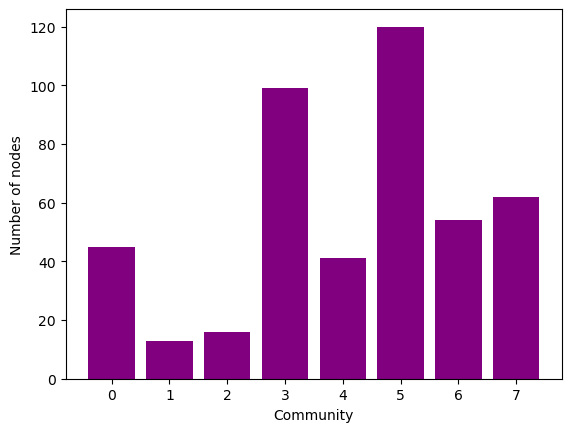

In [190]:
plt.bar(community_index,number_of_nodes, color='purple')
plt.xlabel("Community")
plt.ylabel("Number of nodes")



Centrality in communities


In [191]:
for comm in list_community_sets_library:
    subgraph = L.subgraph(comm)

In [192]:
centr_comm = {}
# node -> centrality in the community subgraph

In [193]:
for comm in list_community_sets_library:
    subgraph = L.subgraph(comm)
    subgraph.order()
    nx.degree_centrality(subgraph)
    
    node_degrees  = nx.degree_centrality(subgraph)
    for n,d in node_degrees.items():
        centr_comm[n] = d

In [194]:
nx.set_node_attributes(L, centr_comm, "centr_comm")

In [195]:
nx.has_bridges(L)

True

In [196]:
nx.write_gexf(L, "L.gexf")